In [20]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm

data_name = "HI-II-14" #HI-II-14, Digg
experiment_type = "ND"
step_ratio = 0.01
read_file_inverse=False
torch_costs = ['degree', 'zero', '001']
tf_costs = ['random', 'degree', 'zero', '001']

In [3]:
def make_dir(path):
    try: os.makedirs(path)
    except: return -1

In [37]:
CNDP_export_path = os.path.join(".", "Baseline_results")
HDA_export_path = os.path.join(CNDP_export_path, "{}_HDA".format(experiment_type))
HPRA_export_path = os.path.join(CNDP_export_path, "{}_HPRA".format(experiment_type))
CI_export_path = os.path.join(CNDP_export_path, "{}_CI".format(experiment_type))
FINDER_torch_export_path = os.path.join(CNDP_export_path, "{}_FINDER_torch".format(experiment_type))
FINDER_tf_export_path = os.path.join(CNDP_export_path, "{}_FINDER_tf".format(experiment_type))

#CI_export_path = os.path.join(CNDP_export_path, "CI")

#make_dir(CNDP_export_path)
make_dir(HDA_export_path)
make_dir(HPRA_export_path)
make_dir(CI_export_path)
make_dir(FINDER_torch_export_path)
make_dir(FINDER_tf_export_path)

-1

In [38]:
# turns node labels into integers from 1 to |V|
# turn this into graph-tool?
def modify_edgelist(data_dir, save_dir, data_name=['day20']):
    for i in range(len(data_name)):
        data = os.path.join(data_dir , data_name[i] + '.edgelist')
        g = nx.read_edgelist(data)

        nodes = g.nodes()
        nodes_l = list(nodes)
        nodes_l_map = map(int, nodes_l)
        nodes_l_int = list(nodes_l_map)
        nodes_l_int.sort()

        nodes_l_map = map(str, nodes_l_int)
        nodes_l = list(nodes_l_map)

        new_node_labels = {}
        for j in range(len(nodes_l)):
            new_node_labels[nodes_l[j]] = str(j)

        new_g = nx.relabel_nodes(g, new_node_labels)

        nx.write_edgelist(new_g, os.path.join(save_dir, "{}_modified.edgelist".format(data_name[i])))

In [39]:
#modify_edgelist(data_dir, save_dir, data_name=['day20'])

In [26]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

G_size = G.number_of_nodes()
#total possible pairwise connectivity
CN_denom = (((G_size * (G_size - 1))) /2)
k = int(G_size * step_ratio)
print("Node removals per iteration: ", k)
print("Total possible pairwise connectivity", int(CN_denom))

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2)

print(_g_num_nodes)
def calc_graph_connectivity(G, experiment_type=experiment_type):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        return maxCC / _g_num_nodes


Number of nodes in the graph: 4165
Number of edges in the graph: 13087
Node removals per iteration:  41
Total possible pairwise connectivity 8671530
4165


In [41]:
'''
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())
'''

'\nnetwork_file_name = "{}_degree".format(data_name)\nnetwork_file_path = "./data/real/cost/{}.gml".format(network_file_name)\nG = nx.read_gml(network_file_path, destringizer=int)\nprint("Number of nodes in the graph:", G.number_of_nodes())\nprint("Number of edges in the graph:", G.number_of_edges())\n'

In [42]:

for node in G.nodes():
    G.nodes[node]['weight'] = 0.01
network_file_path = "./data/real/cost/{}_001.gml".format(data_name)
nx.write_gml(G, network_file_path)


4165


In [43]:
network_comma_export_path = "./data/real/{}_comma.txt".format(network_file_name)
nx.write_edgelist(G, network_comma_export_path, delimiter=",")

In [45]:
# high pageRank adaptive
def HPRA(G, k=k, alpha=0.85, write=True):
    k = int(k)
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_graph_connectivity(G))

    print("HPRA for k: {}, alpha: {}".format(k, alpha))

    while(True):
        print("- ", end="")
        prs = nx.pagerank(G, alpha=alpha)
        prs_sorted = list(sorted(prs.items(), key=lambda item: item[1], reverse=True))

        isTerminal = k > len(prs_sorted)

        num_removals = int(min(k, len(prs_sorted)))
        node_pr_pairs = prs_sorted[0:num_removals]
        node_removals = [i[0] for i in node_pr_pairs]

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(HPRA_export_path, "{}_scores_k_{}_alpha_{}.txt".format(data_name, k, alpha))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list

In [46]:
# high degree adaptive
def HDA(G, k=k, write=True):
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_graph_connectivity(G))

    print("HDA for k: {}".format(k))

    while(True):
        print("- ", end="")
        degrees = dict(G.degree)
        degrees_sorted = list(sorted(degrees.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(degrees_sorted)

        num_removals = int(min(k, len(degrees_sorted)))
        node_degree_pairs = degrees_sorted[0:num_removals]
        node_removals = [i[0] for i in node_degree_pairs]

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return pairwise_conn_list

In [47]:
def calc_score_from_nodes_file(G, node_files, export_path, k=k, write=True, start_idx=1, read_file_inverse=False):
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_graph_connectivity(G))

    f = open(node_files,'r')
    node_removals = []
    for idx, line in enumerate(f.readlines()):
        nodes_line = line.split(",")[start_idx:]
        node_removals = node_removals + nodes_line

    
    node_removals = [int(node_removals[i]) for i in range(len(node_removals))]
    if(read_file_inverse):
        node_removals = node_removals[::-1]
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")
        G.remove_nodes_from(curr_node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list

In [76]:
G = nx.read_gml(network_file_path, destringizer=int)
HDA_scores = HDA(G, k=k)

HDA for k: 41
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [77]:
"""
Alphas = [0.8, 0.85, 0.9]


for alpha in Alphas:
    G = nx.read_gml(network_file_path, destringizer=int)
    print("Successfully imported graph with nodes:", _g_num_nodes)
    HPRA_scores = HPRA(G, k=k, alpha=alpha)
"""

'\nAlphas = [0.8, 0.85, 0.9]\n\n\nfor alpha in Alphas:\n    G = nx.read_gml(network_file_path, destringizer=int)\n    print("Successfully imported graph with nodes:", _g_num_nodes)\n    HPRA_scores = HPRA(G, k=k, alpha=alpha)\n'

In [78]:
exp_dict = {
            "HDA_scores":HDA_scores
           }



In [79]:
# torch
for weight_type in torch_costs:
    network_file_name = "{}_{}".format(data_name, weight_type)

    torch_FINDER_nodefile_degree_scores = None
    FINDER_torch_file_path = os.path.join(".", "code", "results", "FINDER_{}_cost".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                'StepRatio_0.0100', '{}.txt'.format(network_file_name))

    G = nx.read_gml(network_file_path, destringizer=int)

    curr_sccores = calc_score_from_nodes_file(G, FINDER_torch_file_path, FINDER_torch_export_path, k=k, write=True, start_idx=0, read_file_inverse=read_file_inverse)
    exp_dict["torch_{}_scores_nodefile".format(weight_type)] = curr_sccores

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [80]:
# torch from strategy files
for weight_type in torch_costs:

    network_file_name = "{}_{}".format(data_name, weight_type)

    try:
        FINDER_tf_fscores_file = os.path.join(".", "code", "results", "FINDER_{}_cost".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                    'StepRatio_0.0100', 'MaxCCList__Strategy_{}.txt'.format(data_name))
        FINDER_f = open(FINDER_tf_fscores_file, "r")
    except:
        FINDER_tf_fscores_file = os.path.join(".", "code", "results", "FINDER_{}_cost".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                    'StepRatio_0.0100', 'MaxCCList_Strategy_{}.txt'.format(data_name))
        FINDER_f = open(FINDER_tf_fscores_file, "r")

    scores = []
    for score in FINDER_f:
        scores.append(float(score))
    scores = scores[::k]
    exp_dict["torch_{}_scores_scorefile".format(weight_type)] = scores

In [81]:
# NO Cost, Old Tf, 
network_file_name = "{}".format(data_name)
print(k)
FINDER_tf_file_path = os.path.join(".", "code", "results", "old_FINDER_{}_tf".format(experiment_type), 'real','StepRatio_0.0100',
                                   '{}.txt'.format(network_file_name))
no_cost_network_file_path = "./data/real/{}.txt".format(network_file_name)

G = nx.read_edgelist(no_cost_network_file_path, nodetype=int)

FINDER_no_cost_scores = calc_score_from_nodes_file(G, FINDER_tf_file_path, FINDER_tf_export_path, k=k, write=True, start_idx=0, read_file_inverse=read_file_inverse)

network_file_name = "{}".format(data_name)

FINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_tf".format(experiment_type), 'real', \
                            'StepRatio_0.0100', 'MaxCCList_Strategy_{}.txt'.format(data_name))

FINDER_f = open(FINDER_tf_fscores_file, "r")
scores = []
for score in FINDER_f:
    scores.append(float(score))
tf_no_cost_final_scores = scores[::k]

exp_dict["tf_no_cost_scores_nodefile"] = FINDER_no_cost_scores
exp_dict["tf_no_cost_scores_scorefile"] = tf_no_cost_final_scores

41
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [82]:
for weight_type in tf_costs:
    network_file_name = "{}_{}".format(data_name, weight_type)

    torch_FINDER_nodefile_degree_scores = None
    FINDER_torch_file_path = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                'StepRatio_0.0100', '{}.txt'.format(network_file_name))

    G = nx.read_gml(network_file_path, destringizer=int)

    curr_sccores = calc_score_from_nodes_file(G, FINDER_torch_file_path, FINDER_torch_export_path, k=k, write=True, start_idx=0, read_file_inverse=read_file_inverse)
    exp_dict["tf_{}_scores_nodefile".format(weight_type)] = curr_sccores

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [83]:
# tf from strategy files
for weight_type in tf_costs:

    network_file_name = "{}_{}".format(data_name, weight_type)

    try:
        FINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                    'StepRatio_0.0100', 'MaxCCList__Strategy_{}.txt'.format(data_name))
        FINDER_f = open(FINDER_tf_fscores_file, "r")
    except:
        FINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                    'StepRatio_0.0100', 'MaxCCList_Strategy_{}.txt'.format(data_name))
        FINDER_f = open(FINDER_tf_fscores_file, "r")

    scores = []
    for score in FINDER_f:
        scores.append(float(score))
    scores = scores[::k]
    exp_dict["tf_{}_scores_scorefile".format(weight_type)] = scores

In [84]:
"""
weight_type = "random"
network_file_name = "{}_{}".format(data_name, weight_type)

FINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', 'MaxCCList_Strategy_{}.txt'.format(data_name))

FINDER_f = open(FINDER_tf_fscores_file, "r")
tf_degree_scores = []
for score in FINDER_f:
    tf_degree_scores.append(float(score))
tf_random_final_scores = tf_degree_scores[::k]
#print(tf_random_final_scores)
"""

'\nweight_type = "random"\nnetwork_file_name = "{}_{}".format(data_name, weight_type)\n\nFINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), \'real\', \'Data_{}\'.format(weight_type),                            \'StepRatio_0.0100\', \'MaxCCList_Strategy_{}.txt\'.format(data_name))\n\nFINDER_f = open(FINDER_tf_fscores_file, "r")\ntf_degree_scores = []\nfor score in FINDER_f:\n    tf_degree_scores.append(float(score))\ntf_random_final_scores = tf_degree_scores[::k]\n#print(tf_random_final_scores)\n'

In [85]:
k

41

In [88]:
plt_list = ['HDA_scores', "torch_001_scores_scorefile", "torch_001_scores_nodefile",
            "tf_001_scores_scorefile", "tf_001_scores_nodefile", 'tf_no_cost_scores_nodefile']

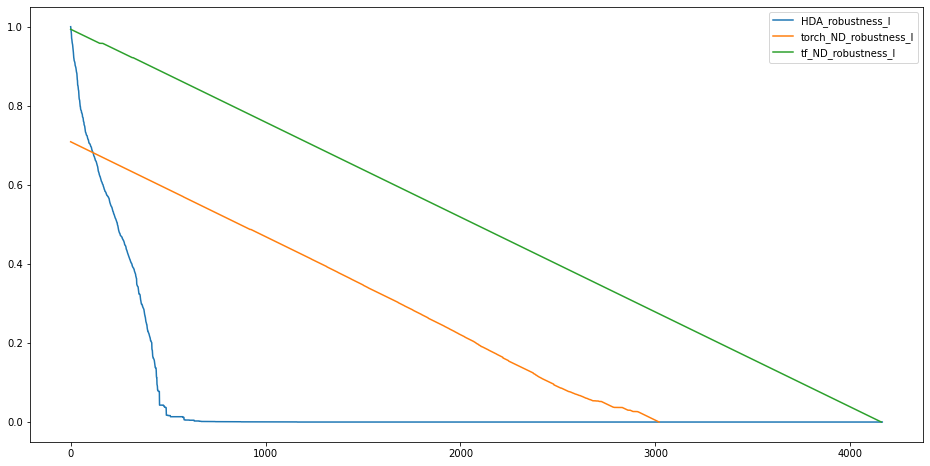

In [25]:
# Reading FINDER files inverse

from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

#plt.plot(CN_scores, label='CN')
for key in plt_list:
    plt.plot(exp_dict[key], label=key)
    
#plt.plot(CI_scores, label='CI')
plt.legend()
plt.xlabel("# iterations of {} node removals".format(k))
plt.ylabel("Graph connectivity {}".format(experiment_type))

In [1]:
import sys
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm

data_name = "HI-II-14" #HI-II-14, Digg
experiment_type = "ND"
step_ratio = 0.01
read_file_inverse=False
torch_costs = ['degree', 'zero', '001']
tf_costs = ['random', 'degree', 'zero', '001']
sys.path.insert(0, "./code/old_FINDER_ND_cost_tf/")


In [2]:
import utils
import graph


In [3]:
my_utils = utils.py_Utils()

In [4]:
def GenNetwork(g):    #networkx2four
        nodes = g.nodes()
        edges = g.edges()
        weights = []
        for i in range(len(nodes)):
            weights.append(g.nodes[i]['weight'])
        if len(edges) > 0:
            a, b = zip(*edges)
            A = np.array(a)
            B = np.array(b)
            W = np.array(weights)
        else:
            A = np.array([0])
            B = np.array([0])
            W = np.array([0])
        return graph.py_Graph(len(nodes), len(edges), A, B, W)

In [5]:
def HXA(g, method):
        # 'HDA', 'HBA', 'HPRA', 'HCA'
        sol = []
        G = g.copy()
        while (nx.number_of_edges(G)>0):
            if method == 'HDA':
                dc = nx.degree_centrality(G)
            elif method == 'HBA':
                dc = nx.betweenness_centrality(G)
            elif method == 'HCA':
                dc = nx.closeness_centrality(G)
            elif method == 'HPRA':
                dc = nx.pagerank(G)
            keys = list(dc.keys())
            values = list(dc.values())
            maxTag = np.argmax(values)
            node = keys[maxTag]
            sol.append(node)
            G.remove_node(node)
        solution = sol + list(set(g.nodes())^set(sol))
        solutions = [int(i) for i in solution]
        Robustness = my_utils.getRobustness(GenNetwork(g), solutions)
        RobustnessList = my_utils.getRobustnessList(GenNetwork(g), solutions)
        maxcclist = my_utils.getRobustnessList(GenNetwork(g), solutions, True)
        return Robustness, RobustnessList, maxcclist

In [6]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
g = nx.read_gml(network_file_path, destringizer=int)
print("Robustness from HDA:")
HDA_robustness, HDA_robustness_l, HDA_maxcclist = HXA(g, "HDA")

Robustness from HDA:


In [7]:
#HDA_maxcclist

In [8]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
g = nx.read_gml(network_file_path, destringizer=int)

weight_type = 'degree'
network_file_name = "{}_{}".format(data_name, weight_type)

FINDER_torch_file_path = os.path.join(".", "code", "results", "FINDER_{}_cost".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', '{}.txt'.format(network_file_name))

f = open(FINDER_torch_file_path,'r')
node_removals = []
for idx, line in enumerate(f.readlines()):
    node_removals.append(int(line))

print("Robustness from torch ND cost:")

torch_ND_robustness = my_utils.getRobustness(GenNetwork(g), node_removals)
torch_ND_robustness_l = my_utils.getRobustnessList(GenNetwork(g), node_removals)
torch_ND_maxcclist = my_utils.getRobustnessList(GenNetwork(g), node_removals, True)


Robustness from torch ND cost:


In [9]:
HDA_robustness_l[-1]

1.0000000000000044

In [10]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
g = nx.read_gml(network_file_path, destringizer=int)

weight_type = 'degree'
network_file_name = "{}_{}".format(data_name, weight_type)

FINDER_tf_file_path = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', '{}.txt'.format(network_file_name))

f = open(FINDER_tf_file_path,'r')
node_removals = []
for idx, line in enumerate(f.readlines()):
    node_removals.append(int(line))

print("Robustness from TF ND cost:")

tf_ND_robustness = my_utils.getRobustness(GenNetwork(g), node_removals)
tf_ND_robustness_l = my_utils.getRobustnessList(GenNetwork(g), node_removals)
tf_ND_maxcclist = my_utils.getRobustnessList(GenNetwork(g), node_removals, True)


Robustness from TF ND cost:


In [11]:
robustness_dict = {"HDA_robustness_l": [HDA_robustness_l, HDA_maxcclist],
                "torch_ND_robustness_l": [torch_ND_robustness_l,torch_ND_maxcclist],
                "tf_ND_robustness_l": [tf_ND_robustness_l, tf_ND_maxcclist]
                }

# Reading FINDER files inverse

from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

#plt.plot(CN_scores, label='CN')
for key in robustness_dict.keys():
    plt.plot(robustness_dict[key][0], robustness_dict[key][1], label=key)

    #plt.plot(robustness_dict[key], label=key)
    
#plt.plot(CI_scores, label='CI')
plt.legend()
#plt.xlabel("# iterations of {} node removals".format(k))
#plt.ylabel("Graph connectivity {}".format(experiment_type))

## RUN cells below for costed analysis:

In [ ]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm

data_name = "HI-II-14" #HI-II-14, Digg
experiment_type = "ND"
step_ratio = 0.01
read_file_inverse=False
torch_costs = ['degree', 'zero', '001']
tf_costs = ['random', 'degree', 'zero', '001']

In [82]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2)

print(_g_num_nodes)
def calc_graph_connectivity(G, experiment_type=experiment_type):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        return maxCC / _g_num_nodes


Number of nodes in the graph: 4165
Number of edges in the graph: 13087
4165


In [83]:
SUM_COST = 0
for i in range(len(G.nodes())):
    SUM_COST += G.nodes[i]['weight']

print(SUM_COST)

91.51748251749102


In [84]:
# high degree adaptive
def cost_HDA(G, k=k, write=True):
    pairwise_conn_list = []
    cost_list = [0]
    pairwise_conn_list.append(calc_graph_connectivity(G))

    print("HDA for k: {}".format(k))

    while(True):
        print("- ", end="")
        degrees = dict(G.degree)
        degrees_sorted = list(sorted(degrees.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(degrees_sorted)

        num_removals = int(min(k, len(degrees_sorted)))
        node_degree_pairs = degrees_sorted[0:num_removals]
        node_removals = [i[0] for i in node_degree_pairs]

        curr_cost = cost_list[-1]
        for n in node_removals:
            curr_cost += G.nodes[n]['weight']
        
        cost_list.append(curr_cost)

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return pairwise_conn_list, cost_list

In [85]:
def cost_calc_score_from_nodes_file(G, node_files, export_path, k=k, write=True, start_idx=1, read_file_inverse=False):
    pairwise_conn_list = []
    cost_list = [0]
    pairwise_conn_list.append(calc_graph_connectivity(G))

    f = open(node_files,'r')
    node_removals = []
    for idx, line in enumerate(f.readlines()):
        nodes_line = line.split(",")[start_idx:]
        node_removals = node_removals + nodes_line

    
    node_removals = [int(node_removals[i]) for i in range(len(node_removals))]
    if(read_file_inverse):
        node_removals = node_removals[::-1]
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")

        curr_cost = cost_list[-1]
        for n in curr_node_removals:
            curr_cost += G.nodes[n]['weight']
        
        cost_list.append(curr_cost)

        G.remove_nodes_from(curr_node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list, cost_list

In [86]:
G = nx.read_gml(network_file_path, destringizer=int)
HDA_scores, HDA_costs = cost_HDA(G, k=k, write=False)

for i in range(len(HDA_costs)): HDA_costs[i] =  HDA_costs[i]/SUM_COST

HDA for k: 41
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


In [87]:
cost_exp_dict = {
                "HDA_robustness_l": [HDA_costs,HDA_scores],
                
                }

In [88]:
for weight_type in ['degree']:
    network_file_name = "{}_{}".format(data_name, weight_type)

    torch_FINDER_nodefile_degree_scores = None
    FINDER_torch_file_path = os.path.join(".", "code", "results", "FINDER_{}_cost".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                'StepRatio_0.0100', '{}.txt'.format(network_file_name))

    G = nx.read_gml(network_file_path, destringizer=int)

    curr_sccores, curr_costs = cost_calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=k, write=False, start_idx=0, read_file_inverse=read_file_inverse)
    for i in range(len(curr_costs)): curr_costs[i] =  curr_costs[i]/SUM_COST
    cost_exp_dict["torch_{}_scores_nodefile".format(weight_type)] = [curr_costs, curr_sccores]

    

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


In [89]:
for weight_type in ['degree']:
    network_file_name = "{}_{}".format(data_name, weight_type)

    torch_FINDER_nodefile_degree_scores = None
    FINDER_torch_file_path = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                                'StepRatio_0.0100', '{}.txt'.format(network_file_name))

    G = nx.read_gml(network_file_path, destringizer=int)

    curr_sccores, curr_costs = cost_calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=k, write=False, start_idx=0, read_file_inverse=read_file_inverse)
    for i in range(len(curr_costs)): curr_costs[i] =  curr_costs[i]/SUM_COST
    cost_exp_dict["tf_{}_scores_nodefile".format(weight_type)] = [curr_costs, curr_sccores]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


Text(0, 0.5, 'Graph connectivity ND')

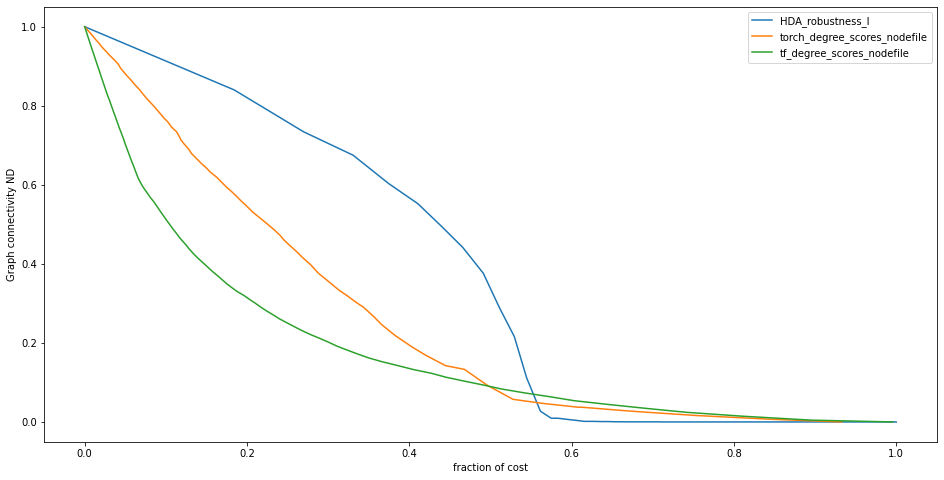

In [90]:

from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key][0], cost_exp_dict[key][1], label=key)

plt.legend()
plt.xlabel("fraction of cost")
plt.ylabel("Graph connectivity {}".format(experiment_type))